**Цель задания**: изучить работу с готовыми моделями из torchvision.

**Контекст**
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

**Задание**
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

Возьмите датасет EMNIST из torchvision
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.
Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

**Инструкция к выполнению задания**

Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
Повторите пункты 2 и 3 для всех указанных вариантов моделей.


In [2]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [15]:
!unzip archive.zip
clear_output()

In [10]:
import PIL
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from itertools import chain
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms

%matplotlib inline

In [11]:
torch.manual_seed(42)
np.random.seed(42)
clear_output()

# Препроцессинг


Изображения разного размера перед обучением моделей необходимо привести их к единому.  Возьмём среднюю длину стороны изображения в датасете и обрежем с помощью transforms.RandomCrop с аргументом pad_if_needed=True все изображения до квадрата с такой длиной стороны.

In [17]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transforms.ToTensor())

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transforms.ToTensor())

In [18]:
lenghts_train = list(chain.from_iterable([img[0][0].numpy().shape[1:]
                                          for img in hymenoptera_train]))

lenghts_val = list(chain.from_iterable([img[0][0].numpy().shape[1:]
                                        for img in hymenoptera_val]))

np.mean(lenghts_train + lenghts_val)

490.90931989924434

In [19]:
transform = transforms.Compose([transforms.RandomCrop(500, pad_if_needed=True,
                                                      padding_mode='reflect'),
                                transforms.ToTensor()])

Теперь составим новый датасет с необходимыми трансформациями.

In [20]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transform)

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transform)

# для удобства объединим загрузчики для обучающей и валидационной выборки в один словарь

loader = {'train': torch.utils.data.DataLoader(hymenoptera_train, batch_size=8,
                                               shuffle=True, num_workers=4),
          'val': torch.utils.data.DataLoader(hymenoptera_val, batch_size=8,
                                             shuffle=True, num_workers=4)}

clear_output()

In [21]:
hymenoptera_train

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(500, 500), padding=None)
               ToTensor()
           )

In [22]:
hymenoptera_val

Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               RandomCrop(size=(500, 500), padding=None)
               ToTensor()
           )

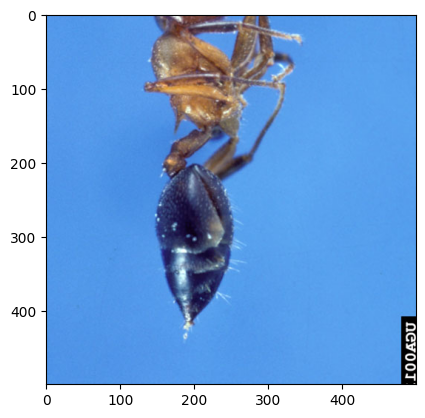

In [23]:
plt.imshow(hymenoptera_train[0][0].numpy().transpose(2, 1, 0))

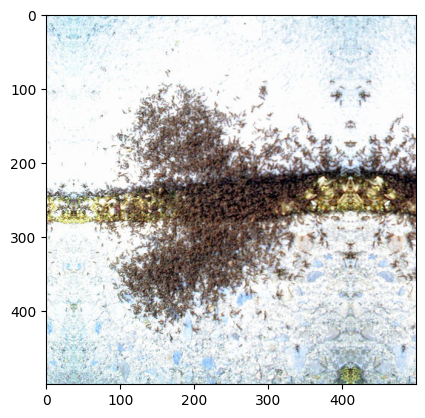

In [24]:
plt.imshow(hymenoptera_val[0][0].numpy().transpose(2, 1, 0))

# Обучение


In [25]:
def train_model(model, loader, criterion, optimizer, n_epochs):
    for epoch in tqdm(range(1, n_epochs + 1)):
        start = time.time()
        losses = []
        accuracies = []
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            curr_loss, curr_acc = 0.0, 0.0
            for X, y in loader[mode]:
                X, y = X.cuda(), y.cuda()
                with torch.set_grad_enabled(mode == 'train'):
                    y_pred = model(X)
                loss = criterion(y_pred, y)
                curr_loss += loss.item()
                curr_acc += (y_pred.argmax(dim=1) == y).sum().item()
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            losses.append(curr_loss / len(loader[mode]))
            accuracies.append(curr_acc / len(loader[mode].dataset))
        stats = """
        Epoch: {}, time: {:.1f}s
        train_loss: {:.3f}, train_acc: {:.3f}
        val_loss: {:.3f}, val_acc: {:.3f}
        """.format(epoch, time.time() - start, losses[0], accuracies[0],
                   losses[1], accuracies[1])
        print(stats)
    print(f'Final validation loss: {losses[1]:.3f}')
    print(f'Final validation accuracy: {accuracies[1]:.3f}')
    return model


### ResNet 18

In [26]:
model = models.resnet18()
model = model.cuda()

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 7.6s
        train_loss: 1.606, train_acc: 0.549
        val_loss: 5.605, val_acc: 0.451
        

        Epoch: 2, time: 6.8s
        train_loss: 0.673, train_acc: 0.615
        val_loss: 0.995, val_acc: 0.588
        

        Epoch: 3, time: 5.9s
        train_loss: 0.650, train_acc: 0.668
        val_loss: 0.751, val_acc: 0.536
        

        Epoch: 4, time: 6.5s
        train_loss: 0.652, train_acc: 0.611
        val_loss: 2.116, val_acc: 0.471
        

        Epoch: 5, time: 5.8s
        train_loss: 0.679, train_acc: 0.643
        val_loss: 0.668, val_acc: 0.601
        

        Epoch: 6, time: 6.3s
        train_loss: 0.662, train_acc: 0.607
        val_loss: 0.650, val_acc: 0.634
        

        Epoch: 7, time: 6.0s
        train_loss: 0.694, train_acc: 0.648
        val_loss: 0.757, val_acc: 0.549
        

        Epoch: 8, time: 6.3s
        train_loss: 0.625, train_acc: 0.652
        val_loss: 0.735, val_acc: 0.641
        

        Epoch: 

### VGG 16

In [29]:
model = models.vgg16()
model = model.cuda()

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 26.4s
        train_loss: 8.267, train_acc: 0.447
        val_loss: 0.794, val_acc: 0.458
        

        Epoch: 2, time: 26.2s
        train_loss: 0.730, train_acc: 0.533
        val_loss: 0.702, val_acc: 0.542
        

        Epoch: 3, time: 26.3s
        train_loss: 0.707, train_acc: 0.484
        val_loss: 0.695, val_acc: 0.458
        

        Epoch: 4, time: 26.9s
        train_loss: 0.724, train_acc: 0.512
        val_loss: 0.722, val_acc: 0.458
        

        Epoch: 5, time: 26.8s
        train_loss: 0.715, train_acc: 0.508
        val_loss: 0.686, val_acc: 0.542
        

        Epoch: 6, time: 27.0s
        train_loss: 0.689, train_acc: 0.553
        val_loss: 0.727, val_acc: 0.458
        

        Epoch: 7, time: 27.1s
        train_loss: 0.747, train_acc: 0.459
        val_loss: 0.694, val_acc: 0.542
        

        Epoch: 8, time: 27.4s
        train_loss: 0.714, train_acc: 0.561
        val_loss: 0.781, val_acc: 0.458
        

       

## ResNet 18 и VGG 16 с FineTuning
### ResNet 18

In [32]:
model = models.resnet18(pretrained=True)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 31.1MB/s]


In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 7.3s
        train_loss: 2.382, train_acc: 0.668
        val_loss: 0.971, val_acc: 0.712
        

        Epoch: 2, time: 6.7s
        train_loss: 0.648, train_acc: 0.680
        val_loss: 0.863, val_acc: 0.745
        

        Epoch: 3, time: 7.5s
        train_loss: 0.568, train_acc: 0.725
        val_loss: 0.352, val_acc: 0.824
        

        Epoch: 4, time: 7.2s
        train_loss: 0.463, train_acc: 0.799
        val_loss: 1.025, val_acc: 0.556
        

        Epoch: 5, time: 6.7s
        train_loss: 0.366, train_acc: 0.844
        val_loss: 0.348, val_acc: 0.850
        

        Epoch: 6, time: 7.2s
        train_loss: 0.321, train_acc: 0.889
        val_loss: 0.433, val_acc: 0.817
        

        Epoch: 7, time: 6.5s
        train_loss: 0.363, train_acc: 0.848
        val_loss: 2.153, val_acc: 0.660
        

        Epoch: 8, time: 6.9s
        train_loss: 0.341, train_acc: 0.861
        val_loss: 0.481, val_acc: 0.824
        

        Epoch: 

### VGG 16

In [35]:
model = models.vgg16(pretrained=True)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 280MB/s]


In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 27.3s
        train_loss: 7.834, train_acc: 0.529
        val_loss: 0.767, val_acc: 0.542
        

        Epoch: 2, time: 27.0s
        train_loss: 1.099, train_acc: 0.455
        val_loss: 0.916, val_acc: 0.458
        

        Epoch: 3, time: 27.1s
        train_loss: 0.774, train_acc: 0.467
        val_loss: 0.694, val_acc: 0.562
        

        Epoch: 4, time: 27.3s
        train_loss: 0.726, train_acc: 0.480
        val_loss: 0.688, val_acc: 0.542
        

        Epoch: 5, time: 27.3s
        train_loss: 0.727, train_acc: 0.512
        val_loss: 0.691, val_acc: 0.536
        

        Epoch: 6, time: 27.2s
        train_loss: 0.761, train_acc: 0.492
        val_loss: 0.707, val_acc: 0.458
        

        Epoch: 7, time: 27.0s
        train_loss: 0.793, train_acc: 0.520
        val_loss: 0.693, val_acc: 0.542
        

        Epoch: 8, time: 26.8s
        train_loss: 1.039, train_acc: 0.492
        val_loss: 0.695, val_acc: 0.458
        

       

## ResNet 18 и VGG 16 с FineTuning и аугментацией
### Аугментация данных


In [43]:

transform_aug_train = transforms.Compose([transforms.RandomResizedCrop(500),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ColorJitter(0.05, 0.05,
                                                                 0.05, 0.05),
                                          transforms.RandomRotation(
                                              20, interpolation=PIL.Image.BILINEAR, expand=False, center=None, fill=0),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.485, 0.456, 0.406),
                                              (0.229, 0.224, 0.225))])



transform_aug_val = transforms.Compose(
    [transforms.RandomCrop(500, pad_if_needed=True, padding_mode='reflect'),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [44]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transform_aug_train)

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transform_aug_val)

loader = {'train': torch.utils.data.DataLoader(hymenoptera_train, batch_size=8,
                                               shuffle=True, num_workers=4),
          'val': torch.utils.data.DataLoader(hymenoptera_val, batch_size=8,
                                             shuffle=True, num_workers=4)}

clear_output()

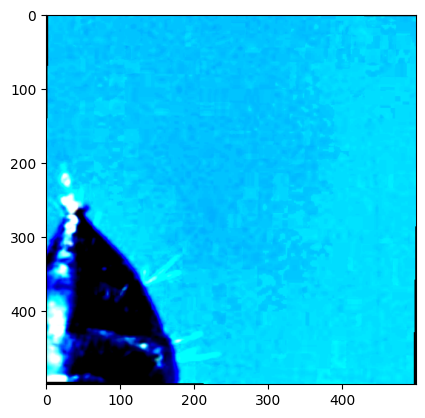

In [45]:
plt.imshow(hymenoptera_train[0][0].numpy().transpose(2, 1, 0))

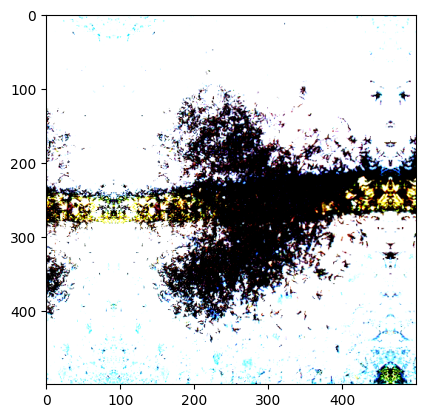

In [46]:
plt.imshow(hymenoptera_val[0][0].numpy().transpose(2, 1, 0))

### ResNet 18

In [47]:
model = models.resnet18(pretrained=True)
model = model.cuda()

In [48]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 12.7s
        train_loss: 1.921, train_acc: 0.574
        val_loss: 2.583, val_acc: 0.562
        

        Epoch: 2, time: 12.6s
        train_loss: 0.665, train_acc: 0.602
        val_loss: 0.707, val_acc: 0.621
        

        Epoch: 3, time: 12.6s
        train_loss: 0.685, train_acc: 0.602
        val_loss: 0.725, val_acc: 0.647
        

        Epoch: 4, time: 12.3s
        train_loss: 0.646, train_acc: 0.619
        val_loss: 0.587, val_acc: 0.719
        

        Epoch: 5, time: 12.7s
        train_loss: 0.657, train_acc: 0.656
        val_loss: 0.556, val_acc: 0.699
        

        Epoch: 6, time: 12.5s
        train_loss: 0.638, train_acc: 0.607
        val_loss: 0.605, val_acc: 0.699
        

        Epoch: 7, time: 12.6s
        train_loss: 0.628, train_acc: 0.668
        val_loss: 0.560, val_acc: 0.693
        

        Epoch: 8, time: 12.6s
        train_loss: 0.615, train_acc: 0.656
        val_loss: 0.636, val_acc: 0.686
        

       

### VGG 16


In [50]:
model = models.vgg16(pretrained=True)
model = model.cuda()

In [51]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
model = train_model(model, loader, criterion, optimizer, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


        Epoch: 1, time: 28.8s
        train_loss: 2.387, train_acc: 0.471
        val_loss: 0.685, val_acc: 0.542
        

        Epoch: 2, time: 28.2s
        train_loss: 1.077, train_acc: 0.443
        val_loss: 0.785, val_acc: 0.549
        

        Epoch: 3, time: 29.0s
        train_loss: 0.908, train_acc: 0.508
        val_loss: 0.684, val_acc: 0.582
        

        Epoch: 4, time: 29.1s
        train_loss: 0.800, train_acc: 0.496
        val_loss: 0.782, val_acc: 0.458
        

        Epoch: 5, time: 28.1s
        train_loss: 0.739, train_acc: 0.520
        val_loss: 0.687, val_acc: 0.542
        

        Epoch: 6, time: 28.1s
        train_loss: 0.750, train_acc: 0.557
        val_loss: 0.671, val_acc: 0.634
        

        Epoch: 7, time: 29.1s
        train_loss: 0.766, train_acc: 0.516
        val_loss: 0.685, val_acc: 0.536
        

        Epoch: 8, time: 28.3s
        train_loss: 1.283, train_acc: 0.492
        val_loss: 0.710, val_acc: 0.458
        

       

# ResNet 18 с FineTuning на датасете FashionMNIST

используем аугментацию – применим случайное аффинное преобразование (поворот на случайный угол до 45 градусов, случайный сдвиг по горизонтали и вертикали не более чем на 0.1 * высоту/ширину изображения, случайное масштабирование с коэффициентом от 0.8 до 1.2) к изображениям из тестовой выборки. Также нормализуем тензоры в обоих выборках после преобразований из изображения в тензор (значений mean и std должно быть по одному, а не по три, т. к., в этом датасете изображения чёрно-белые, а не RGB).

In [53]:
transform_aug_train = transforms.Compose([transforms.RandomAffine(45,
                                                                  (0.1, 0.1),
                                                                  (0.8, 1.2)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=(0.5,),
                                                               std=(0.5,))])

transform_aug_test = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.5,),
                                                              std=(0.5,))])

In [54]:
mnist_train = datasets.FashionMNIST('.', train=True,
                                    transform=transform_aug_train,
                                    download=True)

mnist_test = datasets.FashionMNIST('.', train=False,
                                   transform=transform_aug_test,
                                   download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100)

clear_output()

In [55]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-45.0, 45.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [56]:
mnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

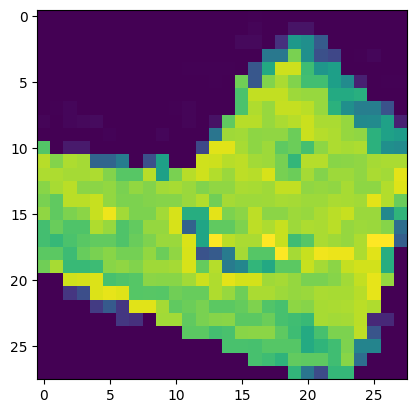

In [57]:
plt.imshow(mnist_train[0][0].numpy().reshape(28, 28))

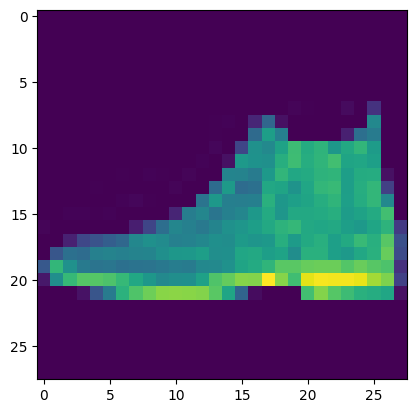

In [58]:
plt.imshow(mnist_test[0][0].numpy().reshape(28, 28))

## Обучение


In [59]:
# берём предобученную модель ResNet 18
model = models.resnet18(pretrained=True)

# устанавливаем для параметров модели requires_grad=False,
# чтобы в архитектуру модели можно было внести изменения
for param in model.parameters():
    param.requires_grad = False

# модифицируем первый слой модели, два основных отличия:
# - принимает на вход 1 канал, а не 3, т. к., в FashionMNIST
#   изображения чёрно-белые, а не RGB
# - шаг сдвига окна свёртки 1, а не 2, соответственно,
#   свёрточный слой рассчитан на изображения 28 * 28, а не 224 * 224
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, padding=3, bias=False)

# модифицируем последний слой модели так,
# чтобы длина каждого предсказания была 10, а не 1000
model.fc = torch.nn.Linear(512, 10)

# сохраняем модифицированные параметры модели на current device
model = model.cuda()

Выводим архитектуру модели. 

In [60]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
def train_model_mnist(model, loader, criterion, optimizer, train=True):
    curr_loss, curr_acc = 0.0, 0.0
    if train:
        model.train()
    else:
        model.eval()
    for X, y in loader:
        X, y = X.cuda(), y.cuda()
        with torch.set_grad_enabled(train):
            y_pred = model(X)
        loss = criterion(y_pred, y)
        curr_loss += loss.item()
        curr_acc += (y_pred.argmax(dim=1) == y).sum().item()
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return curr_loss / len(loader), curr_acc / len(loader.dataset)

In [62]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [63]:
train_losses = []
test_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss, train_acc = train_model_mnist(model, train_loader, criterion,
                                              optimizer)
    test_loss, test_acc = train_model_mnist(model, test_loader, criterion,
                                            optimizer, train=False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    stats = """
    Epoch: {}, time: {:.1f}s
    train_loss: {:.3f}, train_acc: {:.3f}\ttest_loss: {:.3f}, test_acc: {:.3f}
    """.format(epoch, time.time() - start, train_loss, train_acc,
               test_loss, test_acc)
    print(stats)

  0%|          | 0/10 [00:00<?, ?it/s]


    Epoch: 1, time: 32.8s
    train_loss: 1.180, train_acc: 0.584	test_loss: 0.820, test_acc: 0.715
    

    Epoch: 2, time: 33.0s
    train_loss: 0.918, train_acc: 0.668	test_loss: 0.788, test_acc: 0.719
    

    Epoch: 3, time: 32.6s
    train_loss: 0.864, train_acc: 0.687	test_loss: 0.756, test_acc: 0.729
    

    Epoch: 4, time: 33.2s
    train_loss: 0.839, train_acc: 0.697	test_loss: 0.703, test_acc: 0.752
    

    Epoch: 5, time: 33.1s
    train_loss: 0.812, train_acc: 0.709	test_loss: 0.684, test_acc: 0.758
    

    Epoch: 6, time: 32.4s
    train_loss: 0.792, train_acc: 0.714	test_loss: 0.720, test_acc: 0.746
    

    Epoch: 7, time: 32.7s
    train_loss: 0.789, train_acc: 0.716	test_loss: 0.766, test_acc: 0.732
    

    Epoch: 8, time: 33.1s
    train_loss: 0.779, train_acc: 0.719	test_loss: 0.664, test_acc: 0.759
    

    Epoch: 9, time: 33.3s
    train_loss: 0.771, train_acc: 0.724	test_loss: 0.676, test_acc: 0.764
    

    Epoch: 10, time: 32.6s
    train_loss: 0.

In [64]:
stats = """Final accuracy on test sample: {:.3f}
Final loss on training sample: {:.3f}
Final loss on test sample: {:.3f}""".format(test_acc, train_losses[-1],
                                            test_losses[-1])
print(stats)

Final accuracy on test sample: 0.760
Final loss on training sample: 0.775
Final loss on test sample: 0.656


## Оценка качества


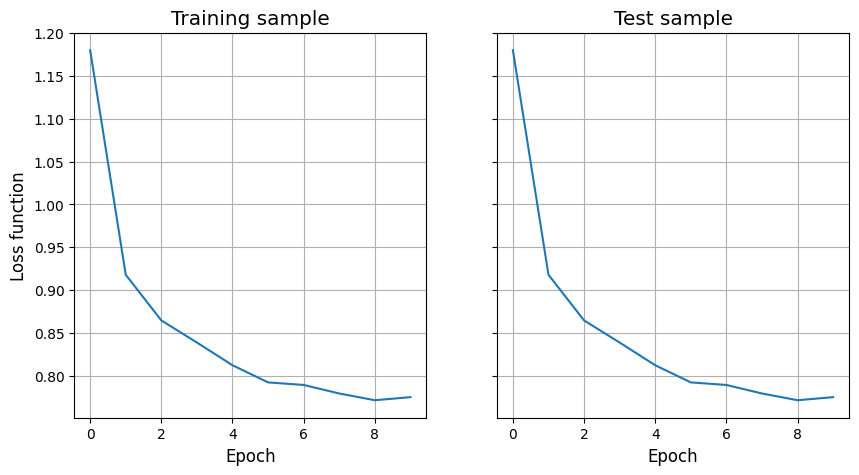

In [65]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax_1.plot(train_losses)
ax_2.plot(train_losses)
ax_1.grid(True)
ax_2.grid(True)
ax_1.set_xlabel('Epoch', fontsize='large')
ax_2.set_xlabel('Epoch', fontsize='large')
ax_1.set_ylabel('Loss function', fontsize='large')
ax_1.set_title('Training sample', fontsize='x-large')
ax_2.set_title('Test sample', fontsize='x-large')
plt.show()

In [66]:
y_true = []
y_pred = []

model.eval()
for X, y in test_loader:
    X, y = X.cuda(), y.cuda()
    y_true.append(y.cpu().numpy())
    y_pred.append(model(X).argmax(dim=1).cpu().numpy())

In [67]:
y_true = list(chain.from_iterable(y_true))
y_pred = list(chain.from_iterable(y_pred))

In [68]:
target_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sheaker', 'Bag', 'Ankle boot']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/Top       0.67      0.81      0.74      1000
     Trouser       0.92      0.93      0.93      1000
    Pullover       0.65      0.60      0.62      1000
       Dress       0.74      0.75      0.75      1000
        Coat       0.54      0.70      0.61      1000
      Sandal       0.88      0.86      0.87      1000
       Shirt       0.52      0.29      0.38      1000
     Sheaker       0.85      0.82      0.84      1000
         Bag       0.93      0.89      0.91      1000
  Ankle boot       0.87      0.93      0.90      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000



Добрый день!
Спасибо за работу!

Всё отлично с обучением моделей с нуля
Только вот еще нужно было заменить последний линейный слой на классификацию на два класса: Linear(in_features=512, out_features=2, bias=True) (это пример для ResNet), так как сейчас классификация идет на 1000 классов (Linear(in_features=512, out_features=1000, bias=True)). Подобное делала для задачи с FashionMNIST
Когда хочется сравнивать разные подходы между собой, то лучше строить сводную таблицу с названиями подходов и их результатами
Получилась отличная работа с экспериментами над сетями